# GPU 어캐쓰는지 모르겠음
오늘은 일단 tensorboard
add scalar? 로 확인해야하는 량
-Epoch 그냥 epoch
-EpRet
-TestEpRet
-EpLen
-TestEp
-TotalEnvInteracts' 그냥 t

In [9]:
from copy import deepcopy
import numpy as np
import torch
from torch.optim import Adam
import gym
import time as time1
import core
#from spinup.utils.logx import EpochLogger

In [10]:
import torch
import torch.nn as nn

In [11]:
from torch.utils.tensorboard import SummaryWriter

In [12]:
writer = SummaryWriter('runs/ddpg/1121_1')

In [13]:
import gymnasium as gym
import gym_examples
import envelope

In [14]:
class ReplayBuffer:
    """
    A simple FIFO experience replay buffer for DDPG agents.
    """

    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf = np.zeros(core.combined_shape(size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros(core.combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(core.combined_shape(size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size) #batch_size 만큼 ReplayBuffer(D)에서 random sampling
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs],
                     done=self.done_buf[idxs])
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in batch.items()}

In [15]:
Fs = 10
N = 500
trans_info = [[{'coeff': 1.0, 'amps': 5 * np.array([-0.0154, -0.011, -0.005414]), 'freqs': [6.48e-3, 5.622e-3, 3.7e-3]},
               {'coeff': 0.01, 'amps': 5 * np.array([0.01237, -0.005816, -0.03928]), 'freqs': [0.01758, 0.005925, 0.002652]}],
              [{'coeff': -0.01, 'amps': 5 * np.array([-0.01568, -0.01486, -0.0064]), 'freqs': [0.00737, 0.0072, -0.0039]},
               {'coeff': 1.0, 'amps': 5 * np.array([-0.0154, -0.011, -0.005414]), 'freqs': [6.48e-3, 5.622e-3, 3.7e-3]}]]
A = envelope.flattop(t0=5.,len=10.,amp=1.,w=1.)
B = envelope.flattop(t0=15.,len=30.,amp=0.8,w=1.)
time = np.arange(N) / Fs  # (ns) 
freq = np.fft.fftfreq(N, d=1/Fs) # (GHz)
initial_state = np.hstack((A(time).astype('float32'),B(time).astype('float32'))) 

<ipython-input-15-20ba2ee0f664>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  initial_state = np.hstack((A(time).astype('float32'),B(time).astype('float32')))


In [16]:
env = gym.make(id='gym_examples/Quantum', Fs=Fs, N=N, initial_state=initial_state,trans_info=trans_info)
test_env = gym.make(id='gym_examples/Quantum', Fs=Fs, N=N, initial_state=initial_state,trans_info=trans_info)

/workspace/RL_CHICAGO/Chicago_RL/gym_examples/envs/Quantum1.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  return transformed_state.astype('float32')


In [17]:
torch.manual_seed(0)
np.random.seed(0)

In [18]:
obs_dim = env.observation_space.shape[0] #(1000
act_dim = env.action_space.shape[0]      #1000
replay_size = int(1e6)
#Action limit
act_limit = env.action_space.high #?

In [ ]:
ac = core.MLPActorCritic(env.observation_space, env.action_space)
ac_targ = deepcopy(ac)

In [ ]:
# Freeze target networks with respect to optimizers (only update ia polyak averaging)
for p in ac_targ.parameters():
    p.requires_grad = False
    
# 그냥 모든 weight and bias 가져와서 update 꺼버리기

In [ ]:
#Experience buffer
replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=replay_size)

In [ ]:
# Set up function for computing DDPG Q-loss
# 여기서 done 대신 terminated 씀
def compute_loss_q(data):
    o, a, r, o2, d = data['obs'], data['act'], data['rew'], data['obs2'], data['done']
    
    q = ac.q(o,a)
    
    #Bellman backup for Q function (target) 
    with torch.no_grad():
        q_pi_targ = ac_targ.q(o2, ac_targ.pi(o2))
        backup = r + gamma * (1-d) * q_pi_targ
        
    loss_q = ((q - backup)**2).mean()
    
    return loss_q

In [ ]:
# Set up function for computing DDPG pi loss
def compute_loss_pi(data):
    o = data['obs']
    q_pi = ac.q(o, ac.pi(o))
    return -q_pi.mean()

In [ ]:
#ddpg 내부에서 정의된 parameter
seed = 0
steps_per_epoch = 1000
epochs = 10
replay_size = int(1e6)
gamma = 0.99
polyak = 0.995
pi_lr = 1e-3
q_lr = 1e-3
batch_size = 100
start_steps = 10000
update_after = 1000
update_every=50
act_noise = 0.1
max_ep_len = 1000
num_test_episodes=10

In [ ]:
# Set up optimizers for policy and q-function
pi_optimizer = Adam(ac.pi.parameters(), lr=pi_lr)
q_optimizer = Adam(ac.q.parameters(), lr=q_lr)

In [ ]:
# logger.setup_pytorch_saver(ac)

In [ ]:
def update(t,data):
# First run one gradient descent step for Q.
    q_optimizer.zero_grad()
    loss_q = compute_loss_q(data)
    loss_q.backward()
    q_optimizer.step()

    # Freeze Q-network so you don't waste computational effort 
    # computing gradients for it during the policy learning step.
    for p in ac.q.parameters():
        p.requires_grad = False

    # Next run one gradient descent step for pi.
    pi_optimizer.zero_grad()
    loss_pi = compute_loss_pi(data)
    loss_pi.backward()
    pi_optimizer.step()

    # Unfreeze Q-network so you can optimize it at next DDPG step.
    for p in ac.q.parameters():
        p.requires_grad = True

    # Record things
    writer.add_scalar("QLoss/train",loss_q.item(),t)
    writer.add_scalar("PiLoss/train",loss_pi.item(),t)
    #logger.store(LossQ=loss_q.item(), LossPi=loss_pi.item(), **loss_info)

    # Finally, update target networks by polyak averaging.
    with torch.no_grad():
        for p, p_targ in zip(ac.parameters(), ac_targ.parameters()):
            # NB: We use an in-place operations "mul_", "add_" to update target
            # params, as opposed to "mul" and "add", which would make new tensors.
            p_targ.data.mul_(polyak)
            p_targ.data.add_((1 - polyak) * p.data)

In [ ]:
def get_action(o, noise_scale):
    a = ac.act(torch.as_tensor(o, dtype=torch.float32))
    a += noise_scale * np.random.randn(act_dim)
    return np.clip(a, -act_limit, act_limit)

In [ ]:
def test_agent(t):
    for j in range(num_test_episodes):
        o, d, ep_ret, ep_len = test_env.reset()[0], False, 0, 0
        while not(d or (ep_len == max_ep_len)):
            # Take deterministic actions at test time (noise_scale=0)
            o, r, d, _, i= test_env.step(get_action(o, 0))
            ep_ret += r
            ep_len += 1
        #logger.store(TestEpRet=ep_ret, TestEpLen=ep_len)
        writer.add_scalar("EpRet/Test",ep_ret,t)
        writer.add_scalar("EpLen/Test",ep_len,t)

In [ ]:
#Prepare for interaction with environment
total_steps = steps_per_epoch * epochs
#start_time = time1.time()
o, ep_ret, ep_len = env.reset()[0], 0, 0

# 지금부터는 main  loop 입니당 호호호

In [ ]:
epoch=0
for t in range(total_steps):
    
    if t > start_steps:
        a = get_action(o, act_noise)
    else:
        a = env.action_space.sample()
    
    # Step the env   d : terminated, _ :truncated=False, i : info={} 
    o2, r, d, _, i = env.step(a)
    #writer.add_scalar("reward",r,t)
    ep_ret += r
    ep_len += 1
    
    # Ignoring done if 강제로 종료당하면 d = False 유지
    d = False if ep_len==max_ep_len else d
    
    replay_buffer.store(o, a, r, o2, d)
    
    o = o2
    
    # End of trajectory handling
    if d or (ep_len == max_ep_len):
        #logger.store(EpRet = ep_ret, Eplen = ep_len)
        writer.add_scalar("EpRet/Train",ep_ret,t)
        writer.add_scalar("EpLen/Train",ep_len,t)
        o, ep_ret, ep_len = env.reset()[0], 0, 0
    
    # Update handling
    if t >= update_after and t % update_every == 0:
        for _ in range(update_every):
            batch = replay_buffer.sample_batch(batch_size)
            update(t,data=batch)
    
    # End of epoch handling
    if (t+1) % steps_per_epoch == 0:
        epoch = (t+1) // steps_per_epoch
        
        #if epoch==epochs:
            #save
        test_agent(t)
        
    
    
    
    

In [ ]:
writer.close()

In [ ]:
ccc=ac.act(torch.as_tensor(initial_state, dtype=torch.float32))

In [ ]:
 bimport matplotlib.pyplot as plt

In [ ]:
fig, ax =plt.subplots()
ax.plot(time, ccc[500:])

Tensorboard

- Epoch
- EpRet
- TestEpRet
- EpLen
- TestEpLen
- TotalEnvInteracts, t
- QVals
- LossPi
- LossQ

#### QVals
compute_loss_q(data)
안에 
q = ac.q(o,a)

loss_info = dict(QVals = q.detach().numpy())

#### LossPi
loss_pi = - ac.q(o,ac.pi(o)).mean()

#### LossQ
loss_q = ((q-backup) ** 2).mean()

logger.store(LossQ=loss_q.item(), LossPi=loss_pi.item(), **loss_info)

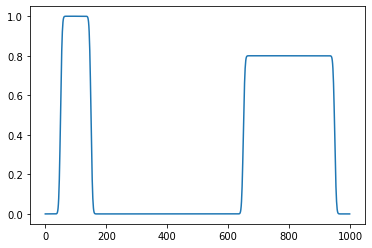

In [19]:
initial_state.shape
fig, ax = plt.subplots()
ax.plot(np.arange(1000),initial_state)

In [28]:
import matplotlib.pyplot as plt

%matplotlib inline 

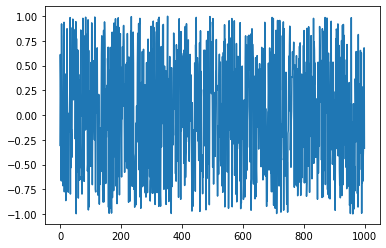

In [29]:
test_action = env.action_space.sample()
fig, ax = plt.subplots()
ax.plot(np.arange(1000),test_action)

In [34]:
c=np.convolve(initial_state[:500],test_action[:500],mode='same')

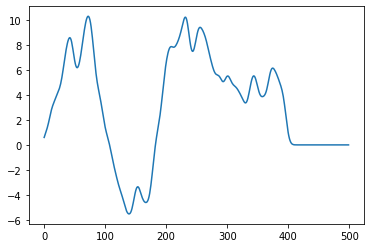

In [35]:
fig,ax=plt.subplots()
ax.plot(np.arange(500),c)